# 데이터 로드 및 전처리

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# OUTPUT_CHANNELS 변수 정의
OUTPUT_CHANNELS = 3  # RGB 이미지 출력을 위해 채널을 3으로 설정

# 데이터 로드 및 전처리
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # 이미지를 원본 이미지와 세그멘테이션으로 분할
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    # 무작위 수평 뒤집기
    input_image = tf.image.random_flip_left_right(input_image)
    real_image = tf.image.random_flip_left_right(real_image)

    # 무작위 회전
    input_image = tf.image.rot90(input_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    real_image = tf.image.rot90(real_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image




# downsample 및 upsample 함수 정의

In [3]:
# downsample 및 upsample 함수 정의
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# U-Net 생성기

In [4]:
# U-Net 생성기
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Encoder 부분
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # Decoder 부분 with skip connections
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)




In [5]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [6]:
# Generator loss
def generator_loss(gen_output, target):
    # Mean Absolute Error (L1 loss)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return l1_loss

# Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# 훈련

In [7]:
# 훈련
def train(dataset, epochs):
    generator = Generator()
    discriminator = Discriminator()

    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    for epoch in range(epochs):
        for input_image, target in dataset:
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_output = generator(input_image, training=True)

                disc_real_output = discriminator([input_image, target], training=True)
                disc_generated_output = discriminator([input_image, gen_output], training=True)

                gen_loss = generator_loss(gen_output, target)
                disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

            generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # 에포크가 끝날 때마다 로그 출력
        print ('Epoch', epoch, 'Generator Loss', gen_loss, 'Discriminator Loss', disc_loss)

    return generator, discriminator  # 학습된 생성기와 판별기를 반환합니다.

# 결과 시각화

In [13]:
# 결과 시각화
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    
    print(test_input.numpy().min(), test_input.numpy().max())  # 값의 범위를 확인합니다.
    print(tar.numpy().min(), tar.numpy().max())
    print(prediction.numpy().min(), prediction.numpy().max())

    # normalize 함수를 정의합니다.
    def normalize(image):
        image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
        image = image * 255  # 이미지의 범위를 [0, 255]로 조정합니다.
        return image

    plt.figure(figsize=(15,15))

    # 각 이미지를 출력하기 전에 normalize 함수를 적용합니다.
    display_list = [normalize(test_input[0]), normalize(tar[0]), normalize(prediction[0])]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.cast(display_list[i], tf.uint8))  # 이미지 값의 범위를 0~255 사이로 조정하고, 정수형으로 변환합니다.
        plt.axis('off')
    plt.show()

# 메인

Epoch 0 Generator Loss tf.Tensor(76.92489, shape=(), dtype=float32) Discriminator Loss tf.Tensor(7.663028, shape=(), dtype=float32)
Epoch 1 Generator Loss tf.Tensor(81.59327, shape=(), dtype=float32) Discriminator Loss tf.Tensor(2.0480618, shape=(), dtype=float32)
Epoch 2 Generator Loss tf.Tensor(48.645676, shape=(), dtype=float32) Discriminator Loss tf.Tensor(1.2514195, shape=(), dtype=float32)
Epoch 3 Generator Loss tf.Tensor(59.440113, shape=(), dtype=float32) Discriminator Loss tf.Tensor(4.787965, shape=(), dtype=float32)
Epoch 4 Generator Loss tf.Tensor(75.56631, shape=(), dtype=float32) Discriminator Loss tf.Tensor(7.0632544, shape=(), dtype=float32)
Epoch 5 Generator Loss tf.Tensor(57.212955, shape=(), dtype=float32) Discriminator Loss tf.Tensor(8.035683, shape=(), dtype=float32)
Epoch 6 Generator Loss tf.Tensor(76.01153, shape=(), dtype=float32) Discriminator Loss tf.Tensor(5.2367907, shape=(), dtype=float32)
Epoch 7 Generator Loss tf.Tensor(78.072044, shape=(), dtype=float32) 

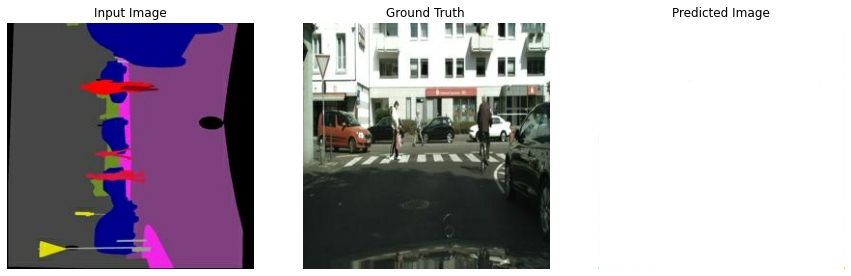

0.0 255.0
0.0 255.0
0.99996233 1.0


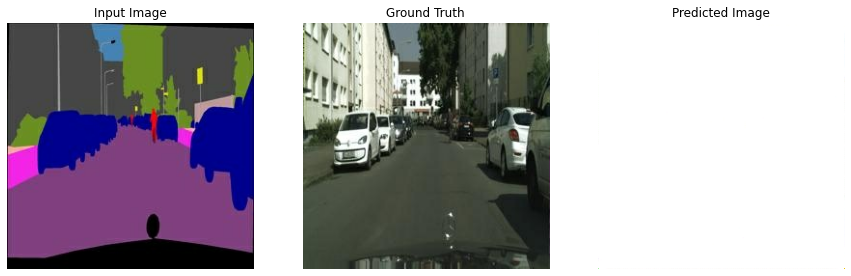

0.0 255.0
0.0 255.0
0.99994636 1.0


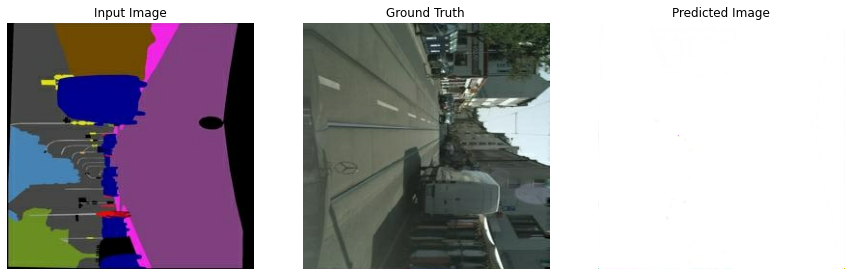

0.0 255.0
0.0 255.0
0.99996316 1.0


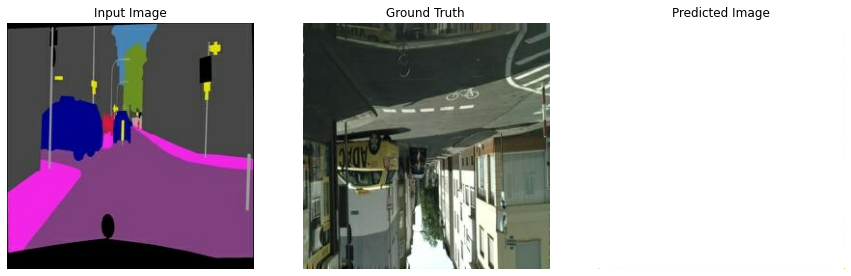

0.0 255.0
0.0 255.0
0.9999535 1.0


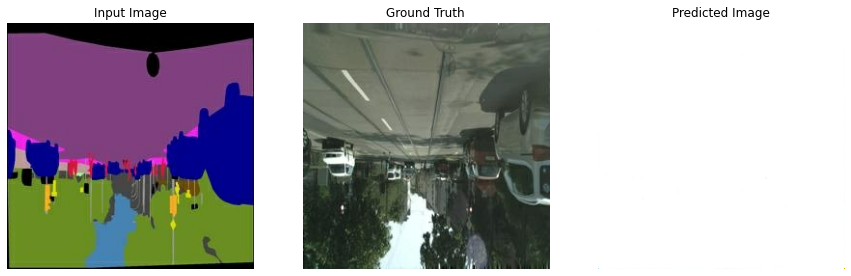

In [15]:
def main():
    # 데이터셋 설정
    train_dataset = tf.data.Dataset.list_files('/aiffel/aiffel/cityscapes/train/*.jpg')
    train_dataset = train_dataset.map(load_image)
    train_dataset = train_dataset.batch(1)

    test_dataset = tf.data.Dataset.list_files('/aiffel/aiffel/cityscapes/val/*.jpg')
    test_dataset = test_dataset.map(load_image)
    test_dataset = test_dataset.batch(1)

    # 훈련
    EPOCHS = 15
    generator, discriminator = train(train_dataset, EPOCHS)  # 학습된 생성기와 판별기를 받습니다.
    
    # 테스트 및 시각화
    for inp, tar in test_dataset.take(5):
        generate_images(generator, inp, tar)  # 학습된 생성기를 사용합니다.

if __name__ == "__main__":
    main()